<a href="https://colab.research.google.com/github/AzizAlbeshri/CSC4260-fluShotLearning/blob/main/fluShotLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
pip install catboost

In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np

# Import SimpleImputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Encoder
from sklearn.preprocessing import OneHotEncoder

# Split data
from sklearn.model_selection import train_test_split

# Classification Algorithims
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier



from sklearn.model_selection import GridSearchCV


# Evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

A function to help plot ROC curve

In [3]:
def plot_roc(y_true, y_score, label_name, ax):
    # Calculate the False Positive Rate and True Positive Rate
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Plot the ROC curve
    ax.plot(fpr, tpr, linestyle='--', color='Blue', label='ROC Curve')

    # Plot the line of no skill
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Chance')

    # Add labels and title
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

    # Add legend
    ax.legend(loc="lower right")


#**Load Dataset**

In [4]:
# Load the datasets
features_df = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features.csv')
labels_df = pd.read_csv('/content/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Labels.csv')

# Combine into one dataframe
df = pd.concat([features_df, labels_df], axis=1)

**Data Inspection**

In [5]:
# Display the first few rows of each dataset to understand their structure
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [6]:
#The first few rows and data types of df_features
print(features_df.head())
print(features_df.dtypes)

   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0               

In [7]:
#The first few rows and data types of labels_df
print(labels_df.head())
print(labels_df.dtypes)

   respondent_id  h1n1_vaccine  seasonal_vaccine
0              0             0                 0
1              1             0                 1
2              2             0                 0
3              3             0                 1
4              4             0                 0
respondent_id       int64
h1n1_vaccine        int64
seasonal_vaccine    int64
dtype: object


# **EDA**

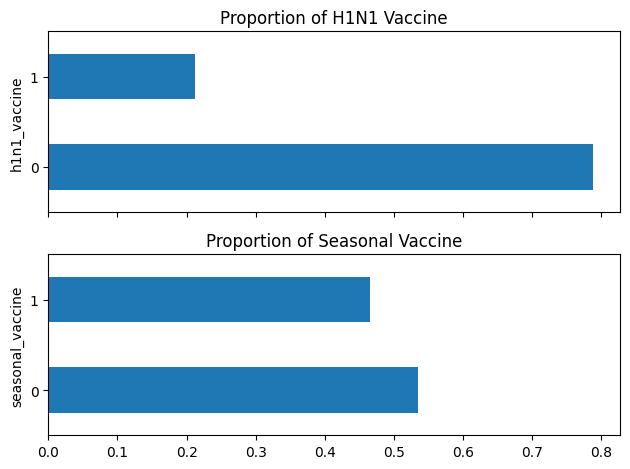

In [8]:
# Create subplots
fig, axes = plt.subplots(2, 1, sharex=True)

# Dataset size
n_obs = labels_df.shape[0]

# Vaccine data and titles for plotting
vaccine_info = [
    ('h1n1_vaccine', "Proportion of H1N1 Vaccine", axes[0]),
    ('seasonal_vaccine', "Proportion of Seasonal Vaccine", axes[1])
]

# Loop through each vaccine type and plot
for vaccine, title, ax in vaccine_info:
    proportion = labels_df[vaccine].value_counts().div(n_obs)
    proportion.plot.barh(ax=ax)
    ax.set_title(title)
    ax.set_ylabel(vaccine)

fig.tight_layout()


About half of the people got seasonal flu vaccine, but only 20% got the h1n1 vaccine. When we look at how many people got each vaccine, the seasonal flu vaccine numbers are balanced, but the H1N1 vaccine seems to be imballanced.

In [9]:
pd.crosstab(
    labels_df["h1n1_vaccine"],
    labels_df["seasonal_vaccine"],
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [10]:
# Phi Coefficient is the same as Pearson for two binary variables
df["h1n1_vaccine"].corr(labels_df["seasonal_vaccine"], method="pearson")

0.37714265306144473



*   A larger proportion of the sample received the seasonal vaccine compared to the H1N1 vaccine.

*   The proportion of people who did not receive any vaccine is the largest single category.

*   Most people who got the H1N1 vaccine had already gotten the seasonal flu vaccine. This shows that people who get the seasonal flu vaccine are also open to getting the H1N1 shot.


Rate plot

In [11]:
def rate_plot(col, target, data, ax=None):

    counts = (df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    #ax.legend().remove()

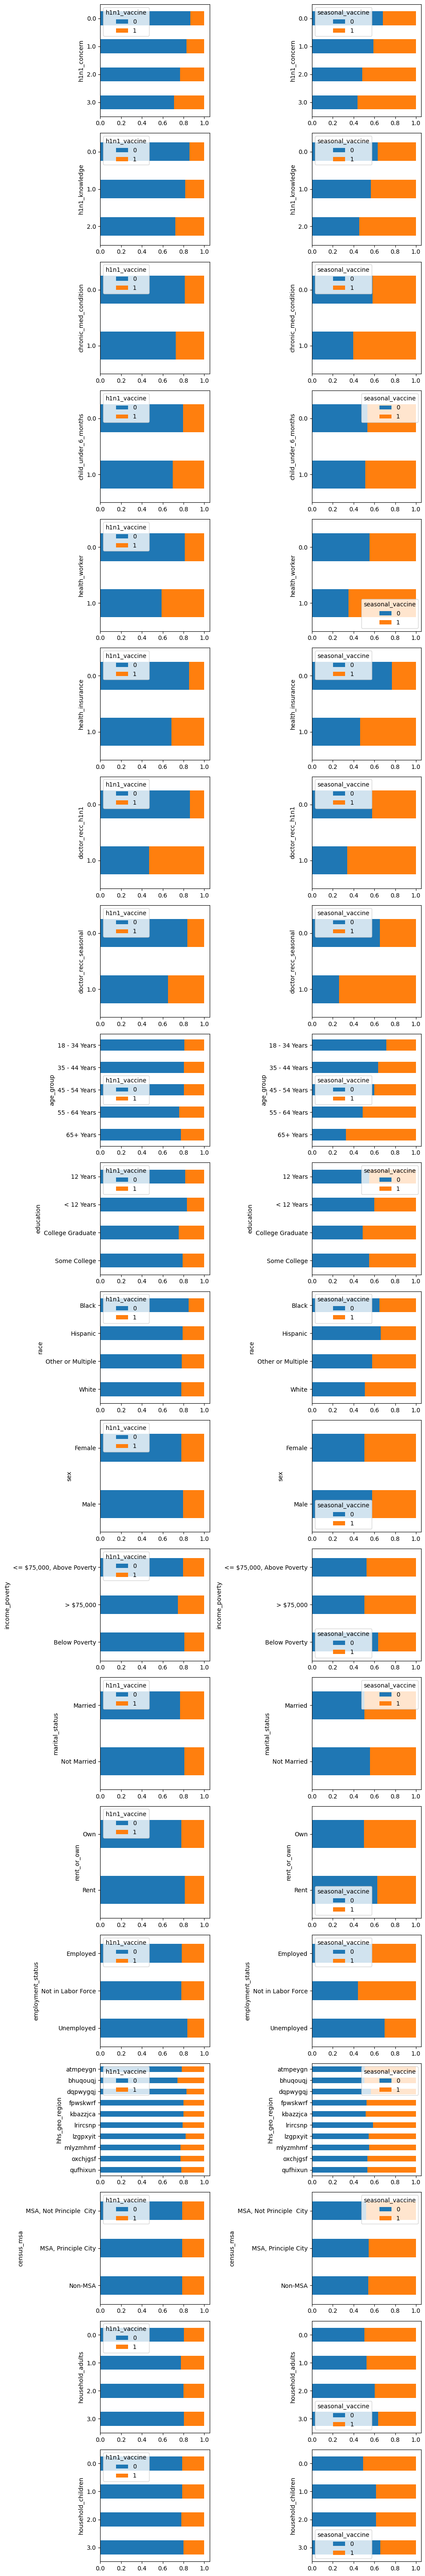

In [12]:
# Define the columns to plot
columns_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'chronic_med_condition',
    'child_under_6_months',
    'health_worker',
    'health_insurance',
    'doctor_recc_h1n1',
    'doctor_recc_seasonal',
    'age_group',
    'education',
    'race',
    'sex',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children'
]

# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(columns_to_plot), 2, figsize=(10, 3 * len(columns_to_plot)))

# Loop through each column and plot
for i, col in enumerate(columns_to_plot):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

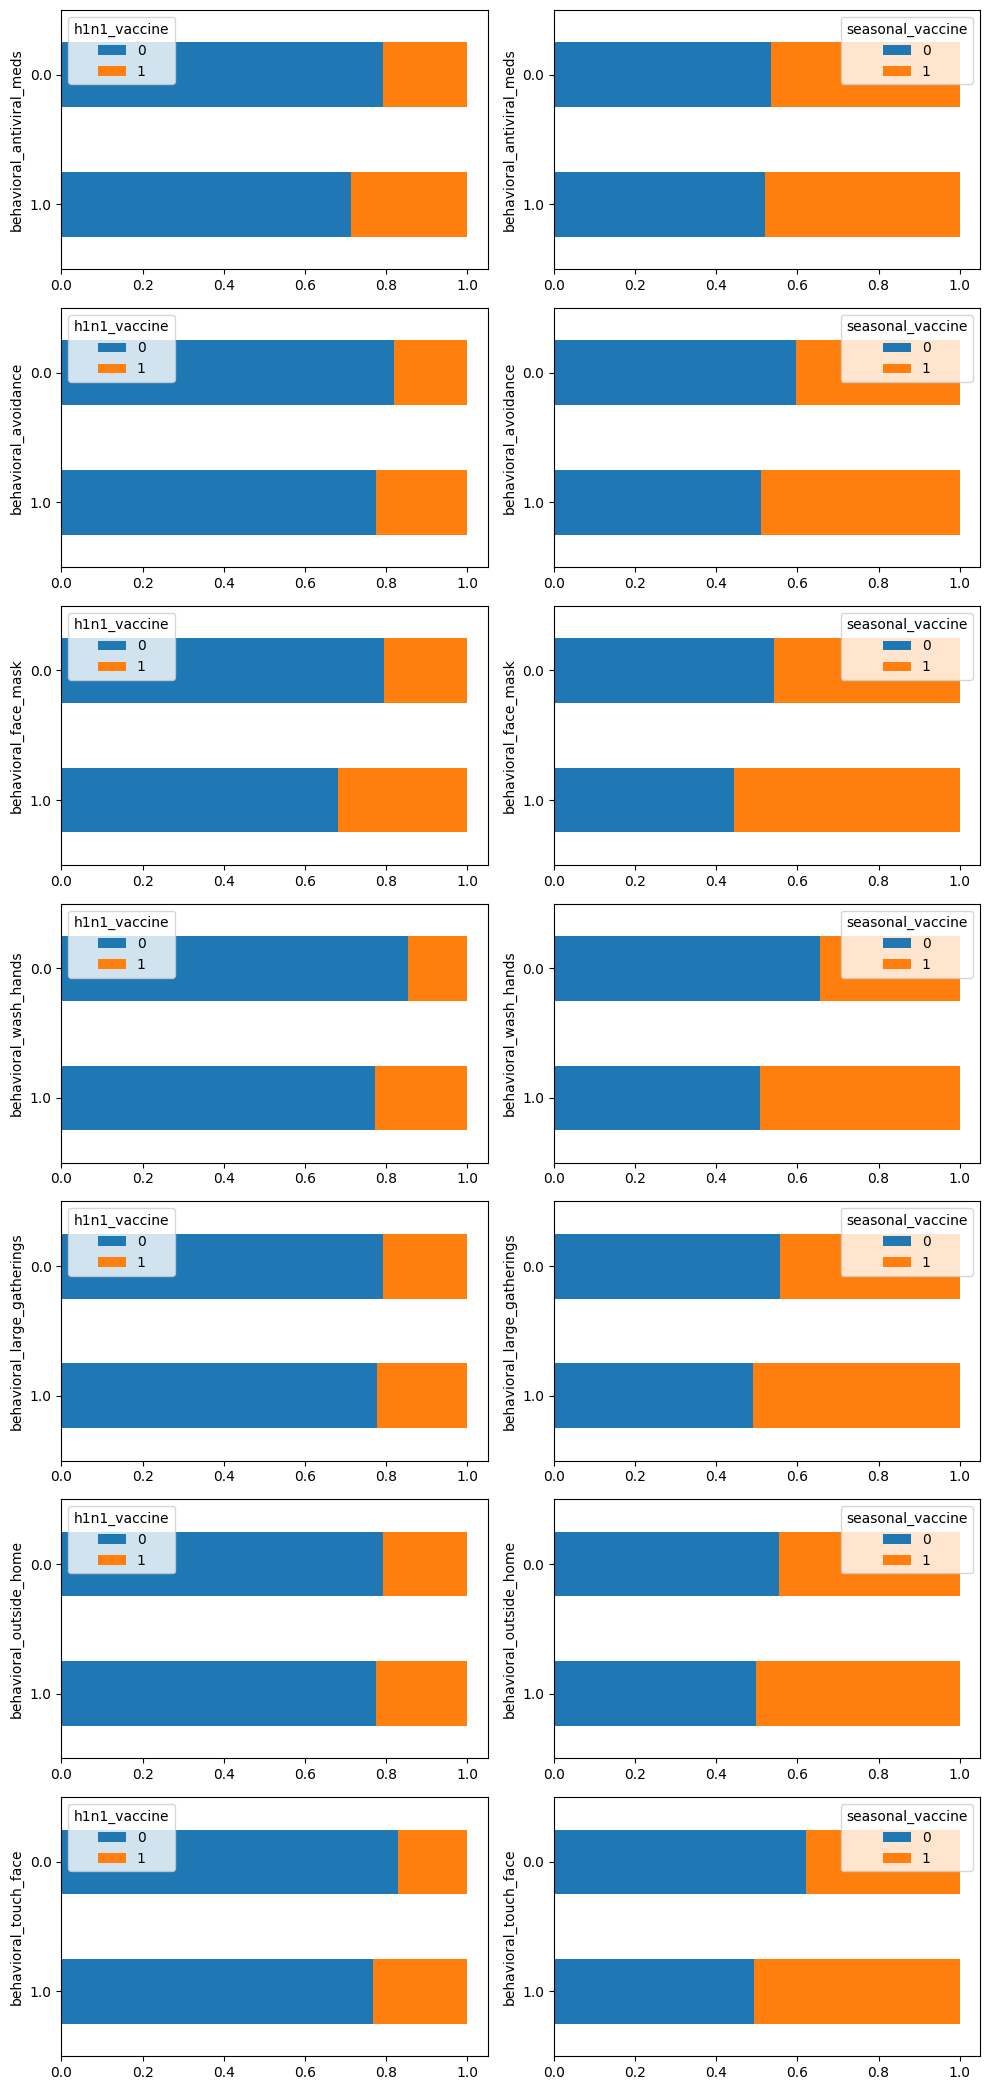

In [13]:
# Plot behaviorl columns

behavioral_columns = [
    'behavioral_antiviral_meds',
    'behavioral_avoidance',
    'behavioral_face_mask',
    'behavioral_wash_hands',
    'behavioral_large_gatherings',
    'behavioral_outside_home',
    'behavioral_touch_face']




# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(behavioral_columns), 2, figsize=(10, 3 * len(behavioral_columns)))

# Loop through each column and plot
for i, col in enumerate(behavioral_columns):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

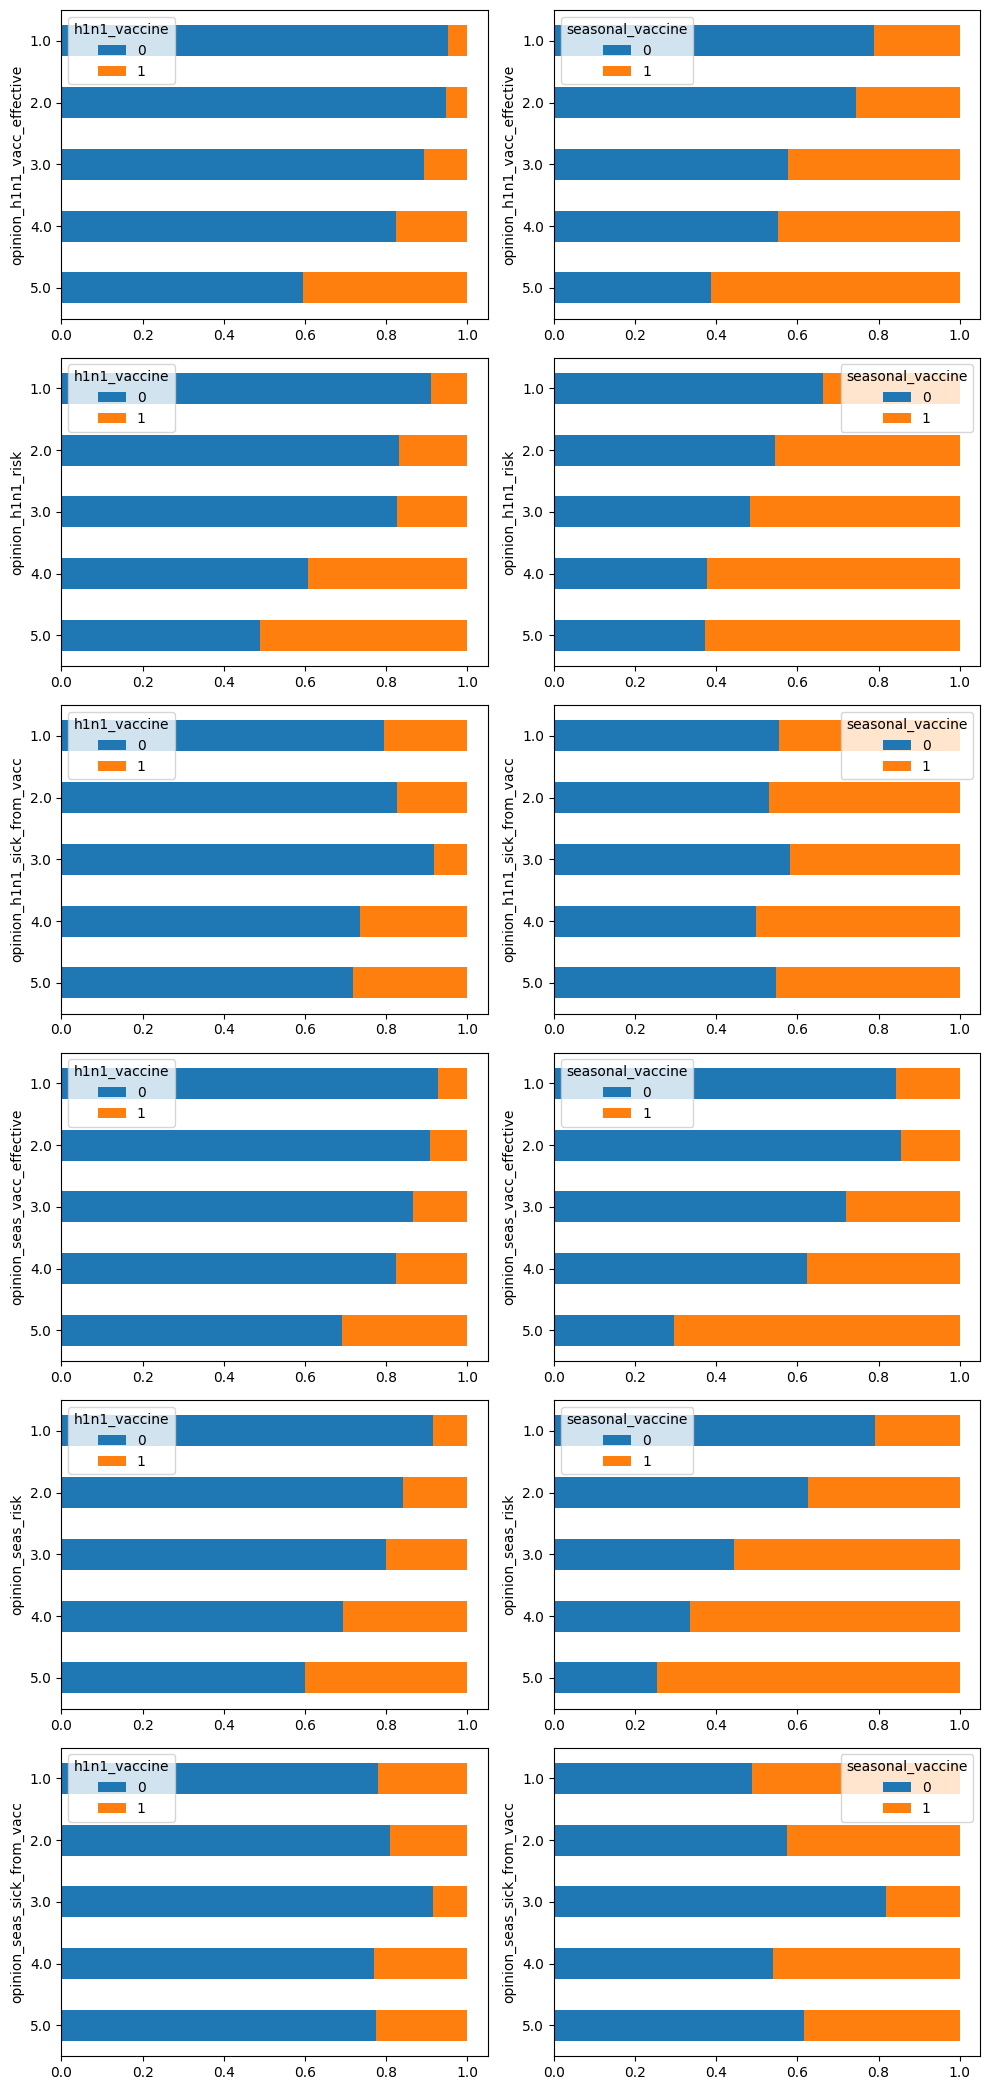

In [14]:
# Plot opinion columns

opinion_columns = [
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc']


# Create a subplot grid layout: 2 rows (for each column) and 2 columns (for each target variable)
fig, axs = plt.subplots(len(opinion_columns), 2, figsize=(10, 3 * len(behavioral_columns)))

# Loop through each column and plot
for i, col in enumerate(opinion_columns):
    rate_plot(col, 'h1n1_vaccine', df, ax=axs[i, 0])
    rate_plot(col, 'seasonal_vaccine', df, ax=axs[i, 1])
    #axs[i, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
    #axs[i, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')

fig.tight_layout()

# **Data preprocessing**

In [15]:
# Set option to display all columns
pd.set_option('display.max_columns', None)
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0


Several columns contain values with commas, < and >, which could impede the model's training process. Therefore, we will proceed to eliminate the commas. Especially, when we use one hot encoding.

In [16]:
# Remove from the specified column
df['income_poverty'] = df['income_poverty'].str.replace(',', '')
df['income_poverty'] = df['income_poverty'].str.replace('<', 'less')
df['income_poverty'] = df['income_poverty'].str.replace('>', 'more')

df['education'] = df['education'].str.replace('<', 'less')

df['census_msa'] = df['census_msa'].str.replace(',', '')


In [17]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,less 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,MSA Not Principle City,0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,less= $75000 Above Poverty,Not Married,Own,Employed,qufhixun,MSA Not Principle City,2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,MSA Principle City,0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,less= $75000 Above Poverty,Married,Own,Employed,qufhixun,MSA Not Principle City,1.0,0.0,wxleyezf,emcorrxb,4,0,0


In [18]:
df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

Upon inspection, our dataset Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_-_Training_Features we noticed:

1-Significant missing values in many columns: notable Columns with High Missing Rates: The employment_occupation, employment_industry, and health_insurance columns have a substantial proportion of missing values, exceeding 45% in some cases. Such a high level of missingness can introduce biases or inaccuracies in predictive models if not addressed appropriately.

2- Diverse Range of Feature Types our dataset comprises a mix of numerical, categorical, and binary features, reflecting a broad spectrum of factors that could influence vaccine uptake.

3-Given the nature of vaccine uptake data, there may be imbalances in the target variables (e.g., more individuals not receiving a vaccine than those who do). This can affect model performance, particularly for classification algorithms.

**Identifying Column Types:**
Numerical and categorical columns are identified to treat them appropriately during preprocessing. 'respondent_id' is removed from the numerical columns as it's not relevant for modeling.

In [19]:
# Identifying numerical and categorical columns
numerical_columns = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = features_df.select_dtypes(include=['object']).columns.tolist()

# Removing 'respondent_id' as it's not a feature for modeling
numerical_columns.remove('respondent_id')

**Imputing Missing Values:**
Imputation is done separately for numerical and categorical using SimpleImputer. For numerical columns, the median is used to fill missing values, while the most frequent category fills gaps in categorical columns. This step addresses missing data, ensuring the model has a complete dataset to learn from.

In [20]:
# Imputing missing values for numerical
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# For categorical
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

**Check Null:** after imputation, we can see there are no null values

In [21]:
  df.isnull().sum()

respondent_id                  0
h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_re

**Encoding Categorical Variables:**
One-hot encoding is applied to categorical features to convert them into a format that can be provided to machine learning algorithms, enhancing model accuracy and interpretability.


In [22]:
# Encoding categorical variables
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(df[categorical_columns])
encoded_feature_names = encoder.get_feature_names_out(categorical_columns)
df_encoded_categorical_features = pd.DataFrame(encoded_categorical, columns=encoded_feature_names)

**Combining Features:**
Merging encoded categorical and numerical features into a single dataframe prepares the final dataset for model training. This step involves concatenating the preprocessed numerical and one-hot encoded categorical features, ensuring the model receives all relevant information.

In [23]:
# Combining encoded categorical features with numerical features
df_preprocessed = pd.concat([df[numerical_columns].reset_index(drop=True), df_encoded_categorical_features.reset_index(drop=True)], axis=1)

In [24]:
df_preprocessed.head(25)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_College Graduate,education_Some College,education_less 12 Years,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,income_poverty_Below Poverty,income_poverty_less= $75000 Above Poverty,income_poverty_more $75000,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,census_msa_MSA Not Principle City,census_msa_MSA Principle City,census_msa_Non-MSA,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,1.0,1.0,4.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,

**Split data**

In [25]:
# Get X features
X = df_preprocessed
# Get y labels
y = labels_df[['h1n1_vaccine', 'seasonal_vaccine']]

30% test data | 70% train data

In [26]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=68)

#**Model Implementation**

##**1st Model: Logistic Regression (baseline model)**

In [64]:
model = LogisticRegression()
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)


multi_output_model.fit(X_train, y_train)
y_pred = multi_output_model.predict(X_test)


# transform prediction into a df
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index = y_test.index
)

ROC AUC SCORE pre-tuning

In [69]:
roc_auc_score(y_test, y_pred)

0.7314672760703449

In [29]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 66.8%


##Hyper Parameter Tuning

In [ ]:
# Define your Logistic Regression model
lr = LogisticRegression(max_iter=10000)

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(lr, n_jobs=-1)

# Hyperparameter obtimization
# Define your parameter grid, adjust based on your needs and computational resources
param_grid = {
    'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'estimator__penalty': ['l1', 'l2'],
    'estimator__solver': ['saga', 'liblinear']  # These solvers support 'l1' penalty.
}


# Setup GridSearchCV, adjust cv (cross-validation strategy) as needed
grid_search = GridSearchCV(estimator=multilabel_model, param_grid=param_grid, cv=3, scoring='accuracy'
, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: ', grid_search.best_params_)

# Use the best model to predict
y_pred = grid_search.predict(X_test)

# Transform prediction into a dataframe
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'estimator__C': 1, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}


In [58]:
# Parameters obtained from Tuning
lr_params = {
    'C': 1,
    'penalty': 'l1',
    'solver': 'saga'
}

model = LogisticRegression(**lr_params)
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)

multi_output_model.fit(X_train, y_train)
y_pred = multi_output_model.predict(X_test)


# transform prediction into a df
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index = y_test.index
)

###**Evaluation (Logistic Regression)**

####**Accuracy**

In [31]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 66.7%


####**Confusion Matrix**

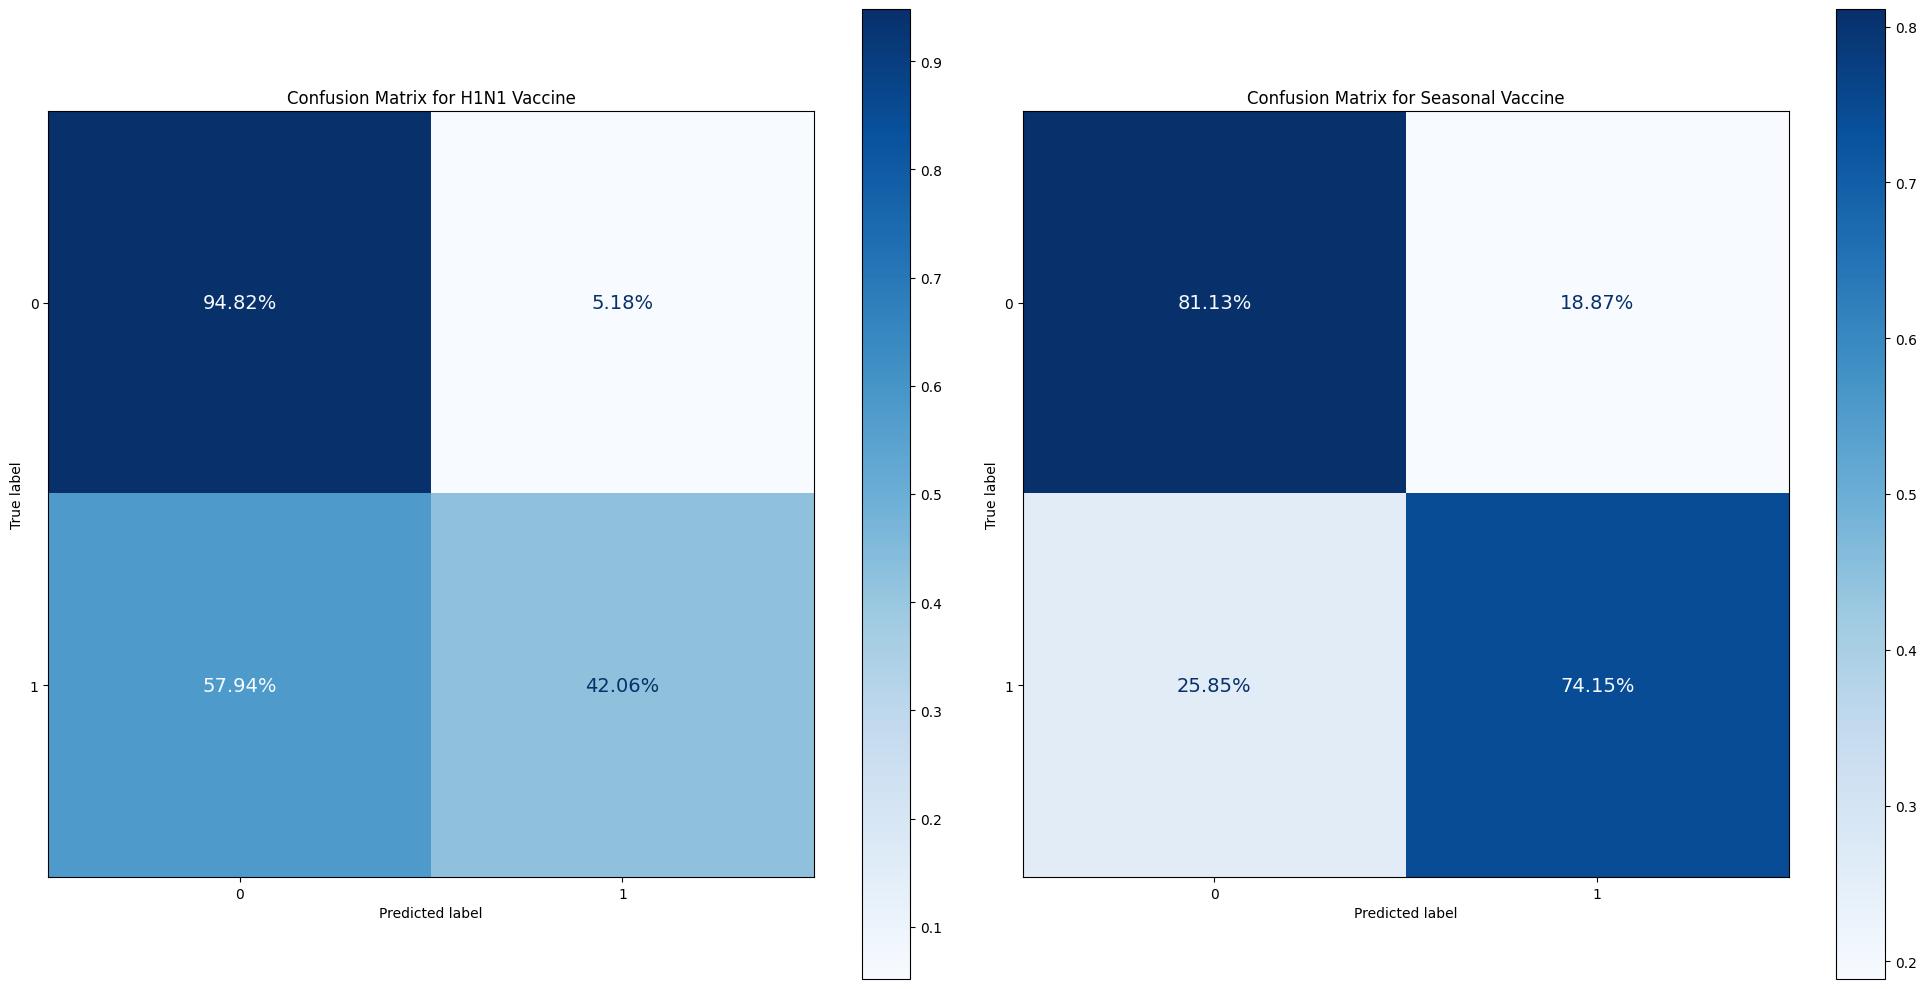

In [32]:
# Computing confusion matrices
cm1 = confusion_matrix(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine'])
cm2 = confusion_matrix(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine'])

# Normalizing the confusion matrices to show percentages
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed

# Plotting the normalized confusion matrix for h1n1_vaccine
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1_normalized, display_labels=np.unique(y_pred[:,0]))
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='.2%')
axes[0].set_title('Confusion Matrix for H1N1 Vaccine')

# Plotting the normalized confusion matrix for seasonal_vaccine
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_normalized, display_labels=np.unique(y_pred[:,1]))
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='.2%')
axes[1].set_title('Confusion Matrix for Seasonal Vaccine')

# Adjusting text size for the confusion matrices
for ax in [axes[0], axes[1]]:
    for text in ax.texts:
        text.set_fontsize(14)  # Increase the fontsize here

# Adjusting layout for better visual presentation
plt.tight_layout()
plt.show()


####**ROC AUC SCORE**

In [33]:
roc_auc_score(y_test, y_pred)

0.7304062899383736

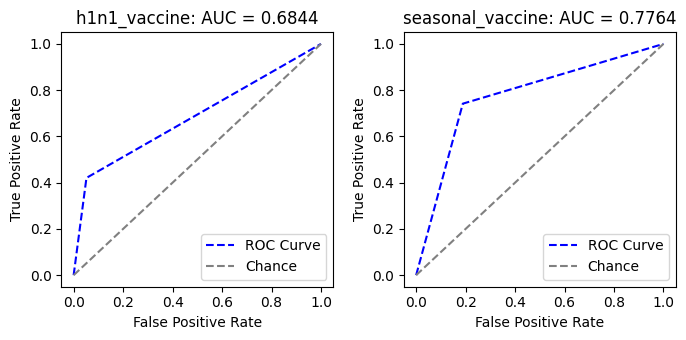

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

##**2nd Model: xgboost classifier**

In [59]:
# Define your Gradient Boosting model
model = xgb.XGBClassifier()

# Create MultiOutputClassifier instance with Gradient Boosting model inside
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)


# Fit the model on the training data
multi_output_model.fit(X_train, y_train)

# Predict on the test data
y_pred = multi_output_model.predict(X_test)


# Transform prediction into a DataFrame
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)


ROC AUC SCORE pre-tuning

In [51]:
roc_auc_score(y_test, y_pred)

0.7341805871877309

In [52]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 66.4%


##Hyper Parameter Tuning

In [ ]:
# Define your XGBoost model
xgb_estimator = xgb.XGBClassifier()

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# Hyperparameter obtimization
# Define your parameter grid, adjust based on your needs and computational resources
param_grid = {
    'estimator__max_depth': [3, 6, 10],
    'estimator__learning_rate': [0.01,0.1, 0.3],
    'estimator__n_estimators': [100, 200, 300],
    'estimator__subsample': [0.8, 1],
    'estimator__colsample_bytree': [0.8, 1],
}


# Setup GridSearchCV, adjust cv (cross-validation strategy) as needed
grid_search = GridSearchCV(estimator=multilabel_model, param_grid=param_grid, cv=3, scoring='accuracy'
, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameter set
print('Best parameters found: ', grid_search.best_params_)

# Use the best model to predict
y_pred = grid_search.predict(X_test)

# Transform prediction into a dataframe
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'estimator__colsample_bytree': 1, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200, 'estimator__subsample': 1}


In [60]:
# Parameters obtained from Tuning
xgb_params = {
    'colsample_bytree': 1,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 200,
    'subsample': 1
}

xgb_estimator = xgb.XGBClassifier(**xgb_params)

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)


 # Fit the model
multilabel_model.fit(X_train, y_train)

# Use the best model to predict
y_pred = multilabel_model.predict(X_test)


# Transform prediction into a dataframe
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)

###**Evaluation (xgboost)**

####Accuracy

In [54]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 67.6%


####Confusion Matrix

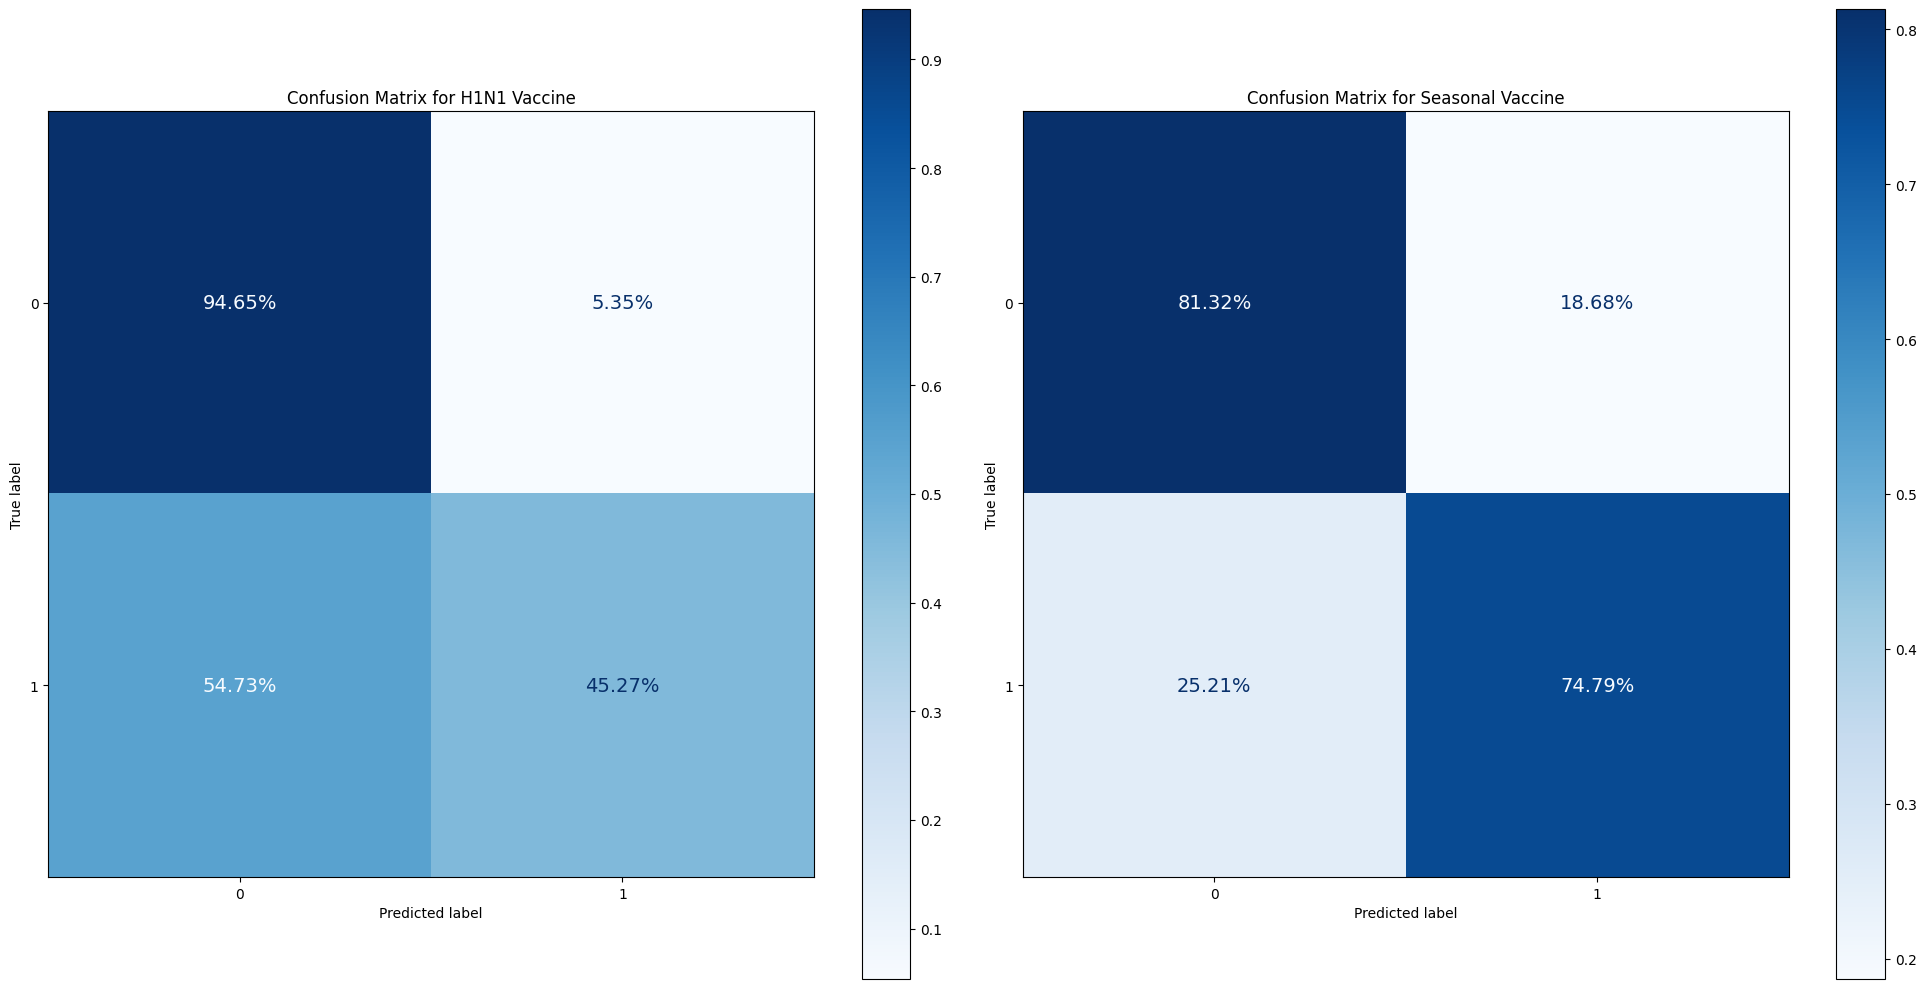

In [39]:
# Computing confusion matrices
cm1 = confusion_matrix(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine'])
cm2 = confusion_matrix(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine'])

# Normalizing the confusion matrices to show percentages
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed

# Plotting the normalized confusion matrix for h1n1_vaccine
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1_normalized, display_labels=np.unique(y_pred[:,0]))
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='.2%')
axes[0].set_title('Confusion Matrix for H1N1 Vaccine')

# Plotting the normalized confusion matrix for seasonal_vaccine
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_normalized, display_labels=np.unique(y_pred[:,1]))
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='.2%')
axes[1].set_title('Confusion Matrix for Seasonal Vaccine')

# Adjusting text size for the confusion matrices
for ax in [axes[0], axes[1]]:
    for text in ax.texts:
        text.set_fontsize(14)  # Increase the fontsize here

# Adjusting layout for better visual presentation
plt.tight_layout()
plt.show()


####ROC AUC SCORE

In [55]:
roc_auc_score(y_test, y_pred)

0.740074935980122

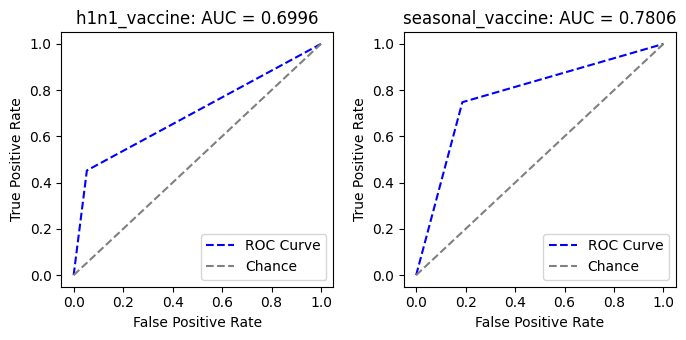

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

##**3rd Model: CatBoostClassifier Model (Best performing model)**



In [63]:
# Define your CatBoost model
model = CatBoostClassifier(verbose=0)  # verbose=0 to keep the output clean, adjust other parameters as needed

# Create MultiOutputClassifier instance with CatBoost model inside
catboost = MultiOutputClassifier(model, n_jobs=-1)


# Fit the model on the training data
catboost.fit(X_train, y_train)

# Predict on the test data
y_pred_catboost = catboost.predict(X_test)


# Transform prediction into a DataFrame
y_preds_catboost = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred_catboost[:, 0],
        "seasonal_vaccine": y_pred_catboost[:, 1],
    },
    index=y_test.index
)


ROC AUC SCORE pre-tuning

In [45]:
catboost_roc_auc_score = roc_auc_score(y_test, y_pred)
catboost_roc_auc_score

0.740074935980122

In [46]:
# evaluate on test data
catboost_accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy on test data: {:.1f}%'.format(catboost_accuracy))

Accuracy on test data: 67.6%


##Hyper Parameter Tuning

In [ ]:
# Define your CatBoost model
model = CatBoostClassifier(verbose=0)  # Keep output clean

# Create MultiOutputClassifier instance with CatBoost model inside
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)

# Define the parameter grid to search over
param_grid = {
    'estimator__iterations': [200, 500],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__depth': [4, 6],
    'estimator__l2_leaf_reg': [5, 10, 12],
    'estimator__random_strength': [2, 4],
    'estimator__one_hot_max_size': [5, 10],
    'estimator__max_bin': [2, 5],
    'estimator__bagging_temperature': [4, 8],
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:", grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.predict(X_test)

# Transform prediction into a DataFrame
y_preds = pd.DataFrame({
    "h1n1_vaccine": y_pred[:, 0],
    "seasonal_vaccine": y_pred[:, 1],
}, index=y_test.index)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Best parameters found: {'estimator__bagging_temperature': 4, 'estimator__depth': 4, 'estimator__iterations': 200, 'estimator__l2_leaf_reg': 10, 'estimator__learning_rate': 0.1, 'estimator__max_bin': 5, 'estimator__one_hot_max_size': 5, 'estimator__random_strength': 2}


In [62]:
# Parameters obtained from Tuning
cb_params = {
    'estimator__bagging_temperature': 4,
    'estimator__depth': 4,
    'estimator__iterations': 200,
    'estimator__l2_leaf_reg': 10,
    'estimator__learning_rate': 0.1,
    'estimator__max_bin': 5,
    'estimator__one_hot_max_size': 5,
    'estimator__random_strength': 2
}

cb_estimator = CatBoostClassifier(verbose=0)

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(cb_estimator)

 # Fit the model
multilabel_model.fit(X_train, y_train)

# Use the best model to predict
y_pred = multilabel_model.predict(X_test)

# Transform prediction into a dataframe
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)

###**Evaluation (CatBoostClassifier)**

####Accuracy

In [48]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 67.7%


####Confusion Matrix

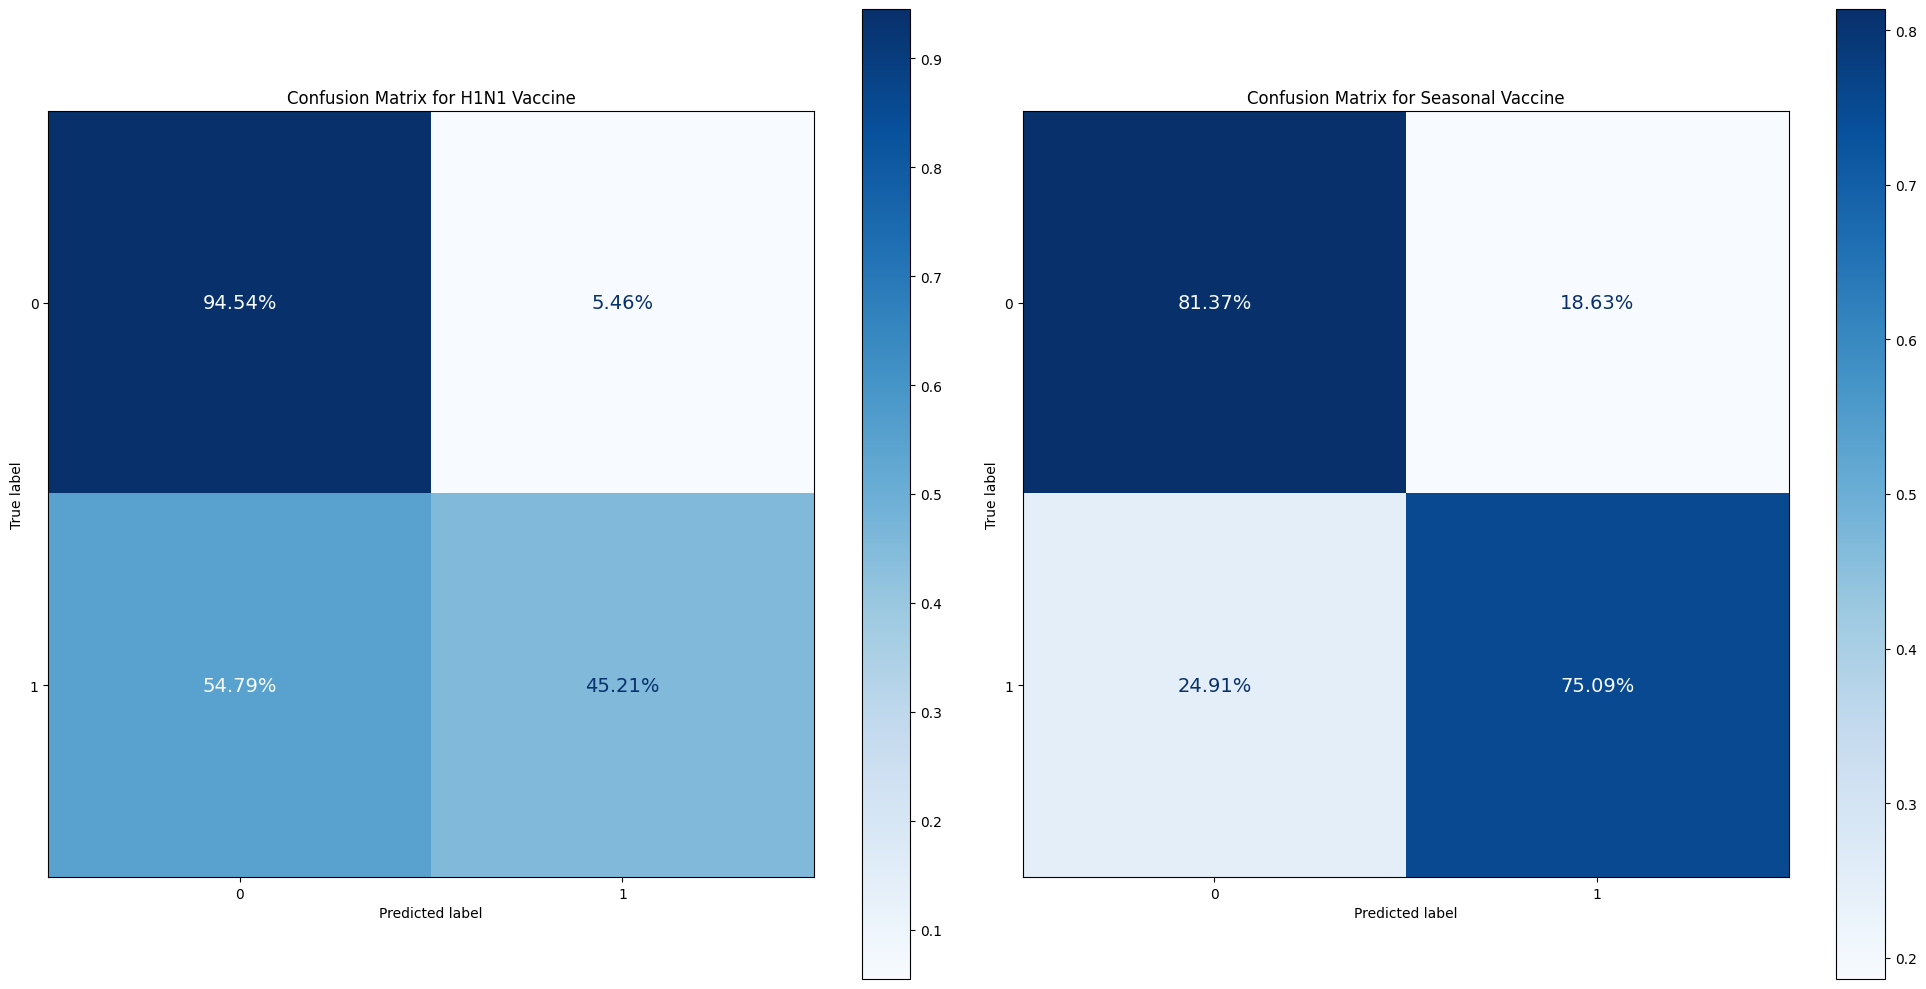

In [ ]:
# Computing confusion matrices
cm1 = confusion_matrix(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine'])
cm2 = confusion_matrix(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine'])

# Normalizing the confusion matrices to show percentages
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed

# Plotting the normalized confusion matrix for h1n1_vaccine
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1_normalized, display_labels=np.unique(y_pred[:,0]))
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='.2%')
axes[0].set_title('Confusion Matrix for H1N1 Vaccine')

# Plotting the normalized confusion matrix for seasonal_vaccine
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_normalized, display_labels=np.unique(y_pred[:,1]))
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='.2%')
axes[1].set_title('Confusion Matrix for Seasonal Vaccine')

# Adjusting text size for the confusion matrices
for ax in [axes[0], axes[1]]:
    for text in ax.texts:
        text.set_fontsize(14)  # Increase the fontsize here

# Adjusting layout for better visual presentation
plt.tight_layout()
plt.show()


####ROC AUC SCORE

In [ ]:
roc_auc_score(y_test, y_pred)

0.7405019797732457

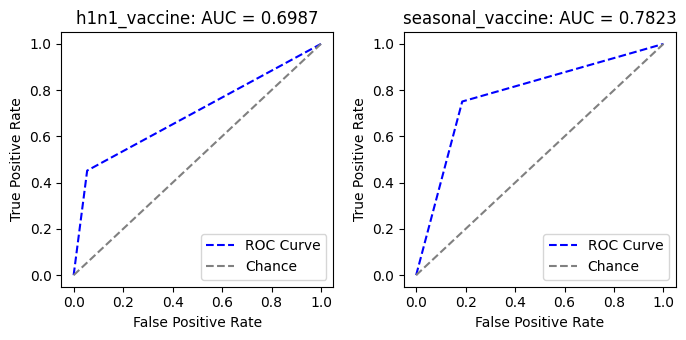

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

##**4th Model:  K-Nearest Neighbors (KNN) Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Define your KNN model
model = KNeighborsClassifier()  # You can specify parameters like n_neighbors if needed

# Create MultiOutputClassifier instance with KNN model inside
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)

# Fit the model on the training data
multi_output_model.fit(X_train, y_train)

# Predict on the test data
y_pred = multi_output_model.predict(X_test)

# Transform prediction into a DataFrame
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)



ROC AUC SCORE pre-tuning

In [ ]:
roc_auc_score(y_test, y_pred)

0.6738375220866748

In [ ]:
# Define your KNN model
model = KNeighborsClassifier()

# Create MultiOutputClassifier instance with KNN model inside
multi_output_model = MultiOutputClassifier(model, n_jobs=-1)

# Define the parameter grid to search over
param_grid = {
    'estimator__n_neighbors': [3, 5, 7, 9, 11],  # Example values for n_neighbors
    'estimator__weights': ['uniform', 'distance'],  # 'uniform' weights or weighted by distance
    'estimator__metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=multi_output_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found:", grid_search.best_params_)

# Predict using the best model
y_pred = grid_search.predict(X_test)

# Transform prediction into a DataFrame
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'estimator__metric': 'manhattan', 'estimator__n_neighbors': 11, 'estimator__weights': 'uniform'}


In [ ]:
# Parameters obtained from Tuning
knn_params = {
    'estimator__metric': 'manhattan',
    'estimator__n_neighbors': 11,
    'estimator__weights': 'uniform'
}

knn_estimator =KNeighborsClassifier()

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(knn_estimator)

 # Fit the model
multilabel_model.fit(X_train, y_train)

# Use the best model to predict
y_pred = multilabel_model.predict(X_test)

# Transform prediction into a dataframe
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred[:, 0],
        "seasonal_vaccine": y_pred[:, 1],
    },
    index=y_test.index
)

###**Evaluation (SVC)**

####Accuracy

In [ ]:
# evaluate on test data
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, y_pred)*100))

Accuracy on test data: 59.8%


####Confusion Matrix

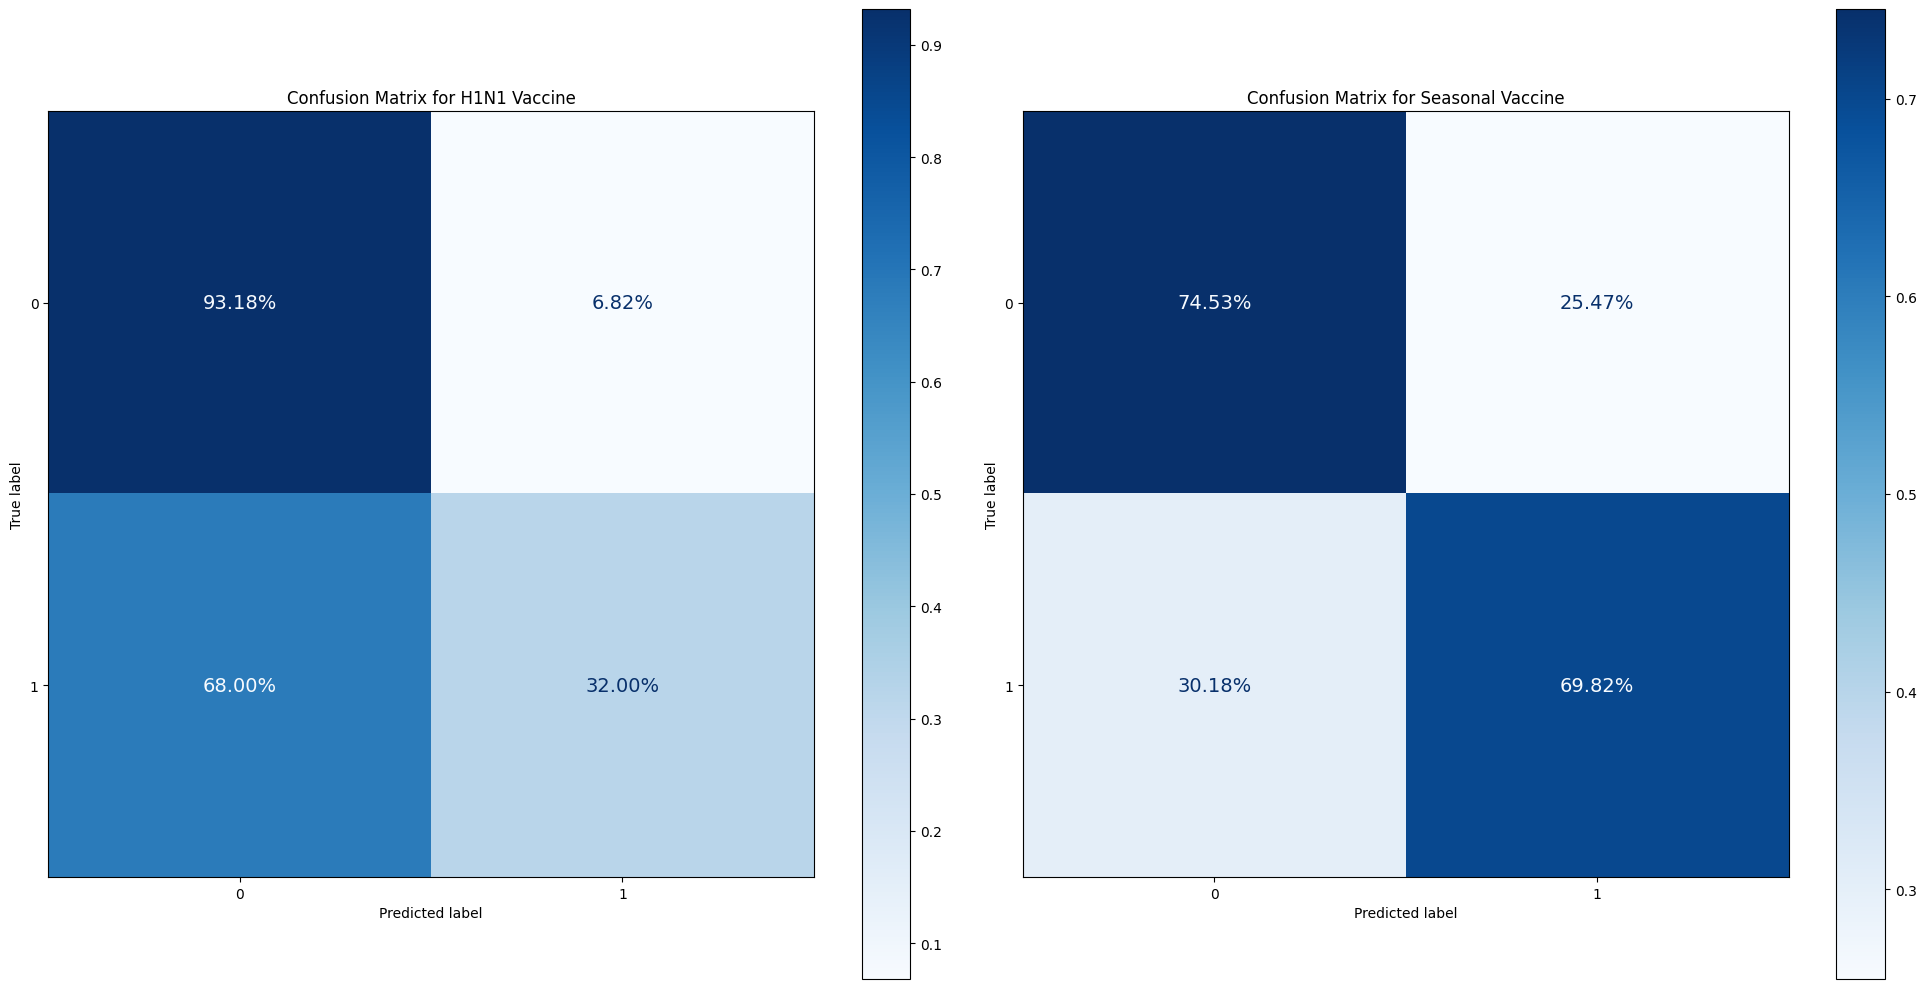

In [ ]:
# Computing confusion matrices
cm1 = confusion_matrix(y_test['h1n1_vaccine'], y_preds['h1n1_vaccine'])
cm2 = confusion_matrix(y_test['seasonal_vaccine'], y_preds['seasonal_vaccine'])

# Normalizing the confusion matrices to show percentages
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed

# Plotting the normalized confusion matrix for h1n1_vaccine
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1_normalized, display_labels=np.unique(y_pred[:,0]))
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='.2%')
axes[0].set_title('Confusion Matrix for H1N1 Vaccine')

# Plotting the normalized confusion matrix for seasonal_vaccine
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_normalized, display_labels=np.unique(y_pred[:,1]))
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='.2%')
axes[1].set_title('Confusion Matrix for Seasonal Vaccine')

# Adjusting text size for the confusion matrices
for ax in [axes[0], axes[1]]:
    for text in ax.texts:
        text.set_fontsize(14)  # Increase the fontsize here

# Adjusting layout for better visual presentation
plt.tight_layout()
plt.show()


####ROC AUC SCORE

In [ ]:
roc_auc_score(y_test, y_pred)

0.6738375220866748

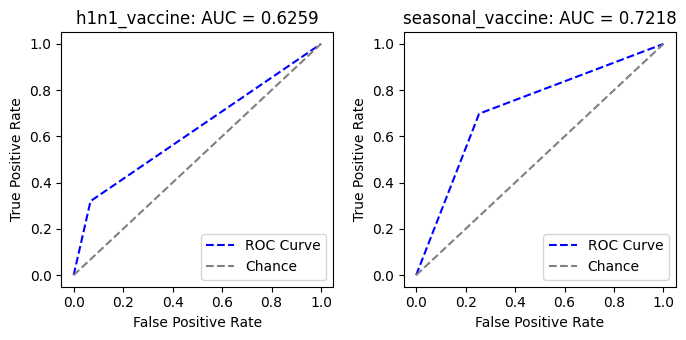

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

#Final Model

Default Catboost Classifier outperformed every model we trained

##**Evaluation**

In [ ]:
print('CatBoost Classifier ROC AUC Score: {:}'.format(catboost_roc_auc_score))

CatBoost Classifier ROC AUC Score: 0.7405019797732457


In [ ]:
print('CatBoost Classifier Accuracy: {:.1f}%'.format(catboost_accuracy))

CatBoost Classifier Accuracy: 67.7%


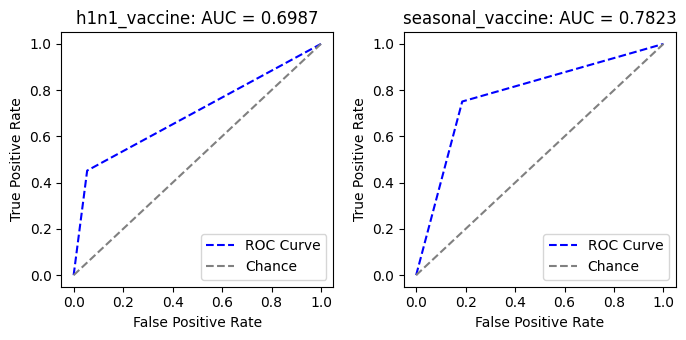

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds_catboost['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds_catboost['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

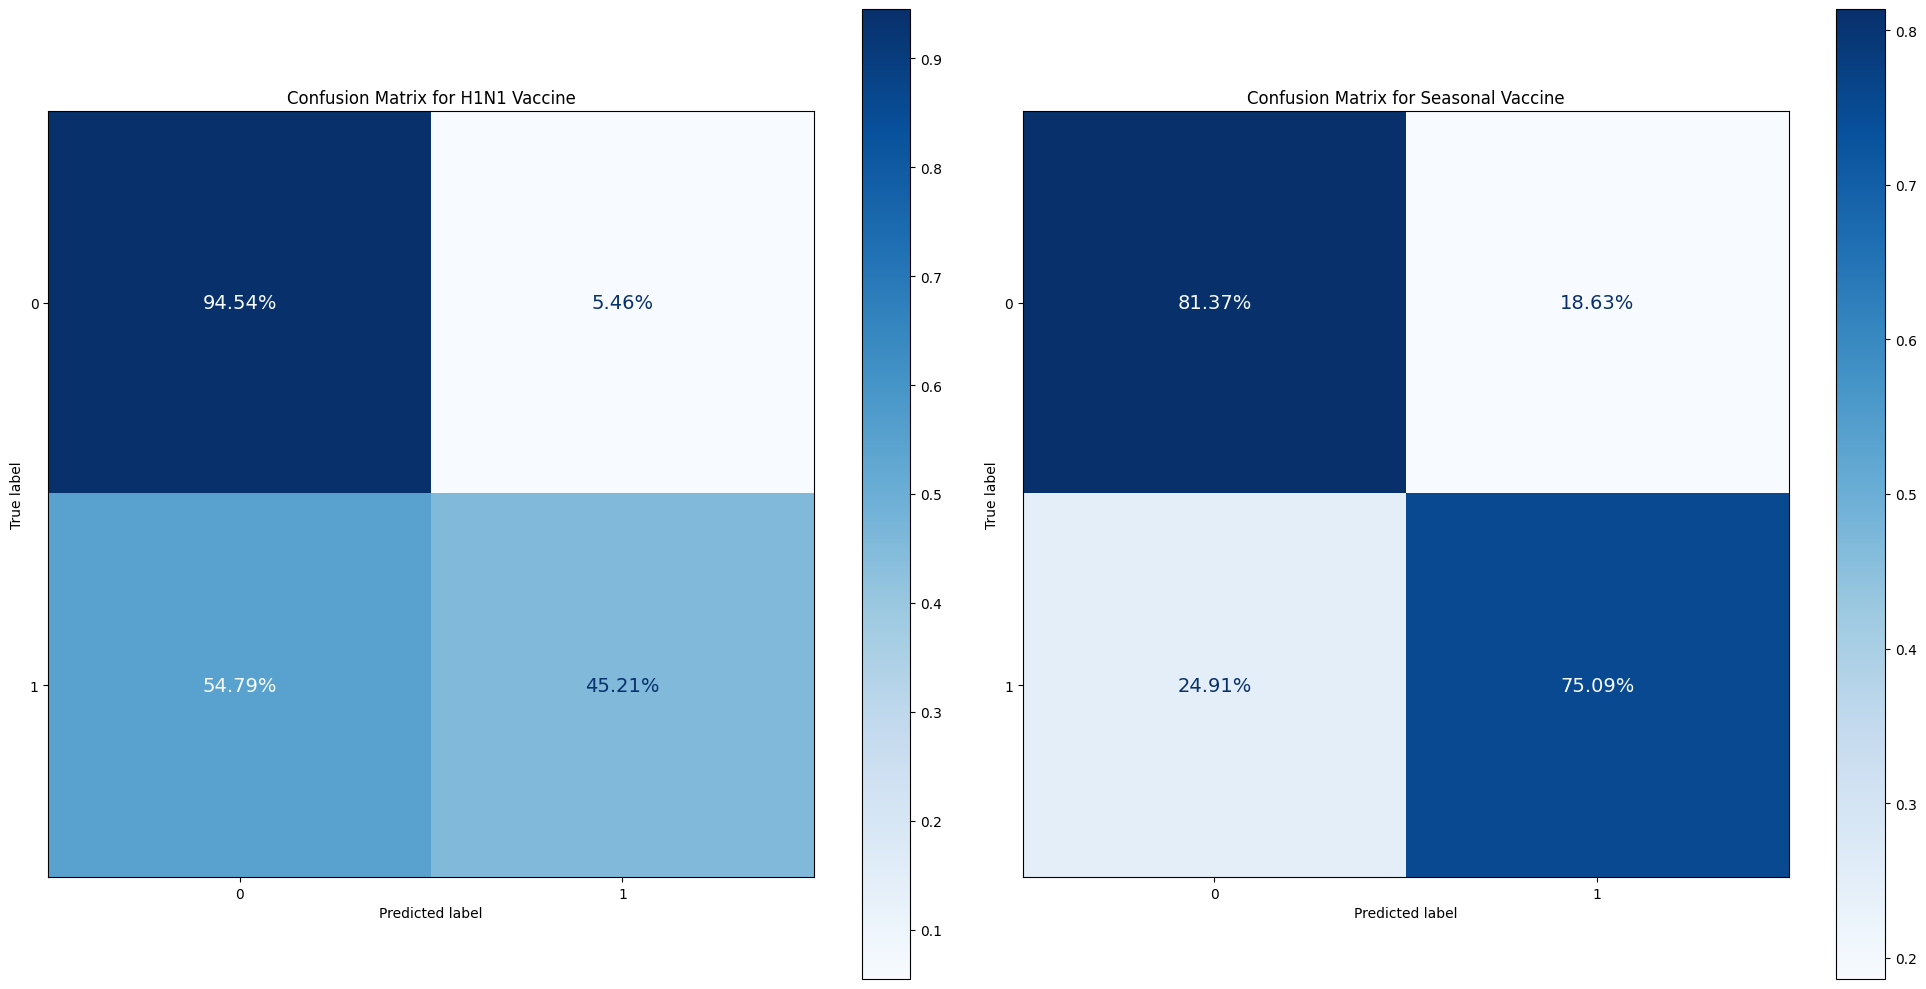

In [ ]:
# Computing confusion matrices
cm1 = confusion_matrix(y_test['h1n1_vaccine'], y_preds_catboost
['h1n1_vaccine'])
cm2 = confusion_matrix(y_test['seasonal_vaccine'], y_preds_catboost
['seasonal_vaccine'])

# Normalizing the confusion matrices to show percentages
cm1_normalized = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))  # Adjust figsize as needed

# Plotting the normalized confusion matrix for h1n1_vaccine
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1_normalized, display_labels=np.unique(y_pred_catboost[:,0]))
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='.2%')
axes[0].set_title('Confusion Matrix for H1N1 Vaccine')

# Plotting the normalized confusion matrix for seasonal_vaccine
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_normalized, display_labels=np.unique(y_pred_catboost[:,1]))
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='.2%')
axes[1].set_title('Confusion Matrix for Seasonal Vaccine')

# Adjusting text size for the confusion matrices
for ax in [axes[0], axes[1]]:
    for text in ax.texts:
        text.set_fontsize(14)  # Increase the fontsize here

# Adjusting layout for better visual presentation
plt.tight_layout()
plt.show()


##**Feature Importance**

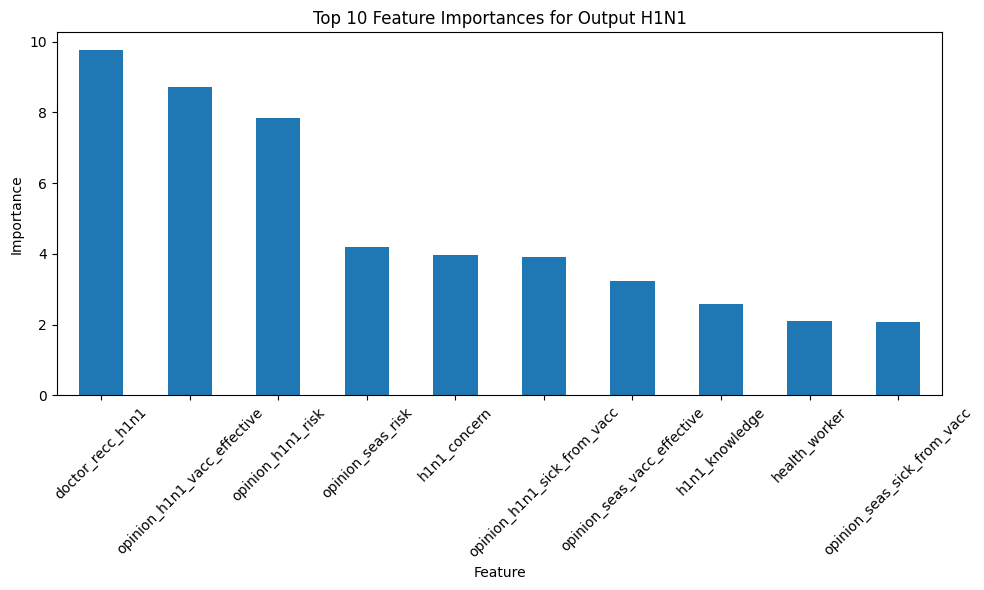

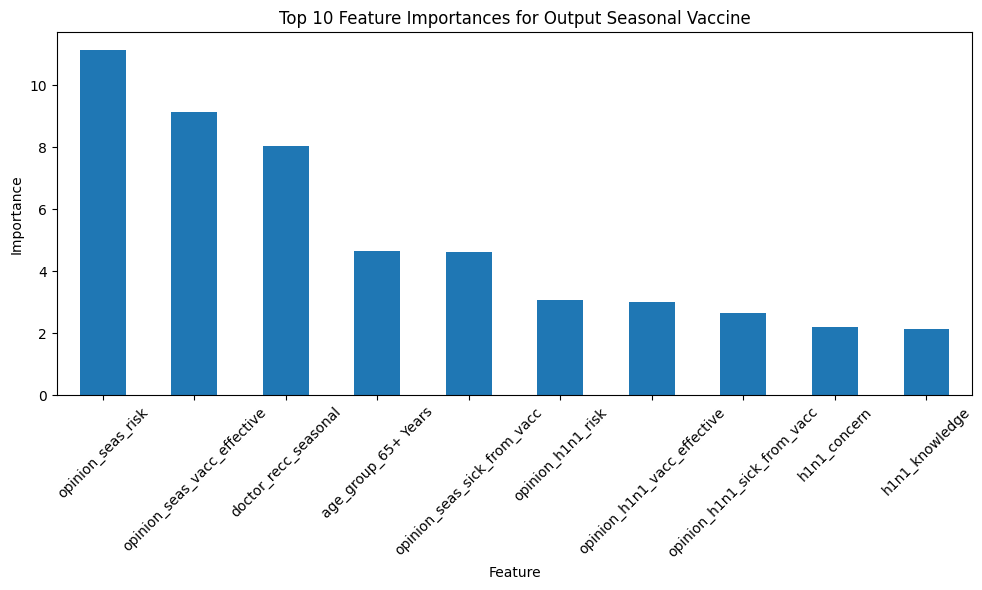

In [ ]:
# Assume X_train is a DataFrame for this example; if not, you should adjust accordingly.
feature_names = X_train.columns

# Initialize a DataFrame to hold feature importances
feature_importances_df = pd.DataFrame()

# Loop through each fitted classifier (one for each target)
for i, estimator in enumerate(catboost.estimators_):
    # Extract feature importances and make them a DataFrame
    importances = pd.DataFrame({
        'Feature': feature_names,
        f'Importance_{i}': estimator.feature_importances_
    })

    # Append to the main DataFrame
    if feature_importances_df.empty:
        feature_importances_df = importances
    else:
        feature_importances_df[f'Importance_{i}'] = importances[f'Importance_{i}']

# Now feature_importances_df contains the importances for each output

# Plotting feature importances for top 10 features only
for i in range(len(catboost.estimators_)):
    # Define the figure size
    plt.figure(figsize=(10, 6))

    # Sort the features based on their importance and select the top 10
    top_features = feature_importances_df.sort_values(by=f'Importance_{i}', ascending=False).head(10)

    # Plot the top 10 features
    ax = top_features.plot(
        x='Feature',
        y=f'Importance_{i}',
        kind='bar',
        legend=False,
        ax=plt.gca()
    )

    # Set the title for the first output
    if i == 0:
        ax.set_title('Top 10 Feature Importances for Output H1N1')
    else:
        ax.set_title(f'Top 10 Feature Importances for Output Seasonal Vaccine')

    # Label the y-axis
    ax.set_ylabel('Importance')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()
